In [15]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams, gridspec
from pandas.api.types import CategoricalDtype

import sklearn
from sklearn import model_selection
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import cdist

In [2]:
customers = pd.read_csv('insurance_marketing_data.csv', encoding='latin')
regions = pd.read_csv('us_state_regions.csv', encoding='latin')

In [3]:
customers.head()

,Customer,State,CLV,Coverage,Education,EmploymentStatus,Gender,Income,LocationCode,MaritalStatus,...,MonthsSincePolicyInception,NumberOfOpenComplaints,NumberOfPolicies,PolicyType,Policy,RenewOfferType,SalesChannel,TotalClaimAmount,VehicleClass,VehicleSize
0,DP39365,California,8798.797003,Premium,Master,Employed,M,77026,Urban,Married,...,82,2,3,Corporate Auto,Corporate L1,Offer2,Agent,472.029737,Four-Door Car,Medsize
1,HO30839,Washington,5346.916576,Extended,Master,Disabled,F,10511,Urban,Married,...,64,0,1,Corporate Auto,Corporate L1,Offer1,Branch,516.237951,SUV,Medsize
2,SK67821,Oregon,4932.916345,Basic,Bachelor,Employed,F,37260,Rural,Married,...,42,0,8,Corporate Auto,Corporate L1,Offer3,Web,15.437681,Four-Door Car,Medsize
3,PY51963,California,33473.349460,Basic,Bachelor,Employed,F,33190,Suburban,Divorced,...,95,0,2,Corporate Auto,Corporate L1,Offer1,Web,508.800000,SUV,Medsize
4,WK30175,Oregon,2672.095756,Basic,Bachelor,Employed,M,52822,Suburban,Married,...,88,0,1,Corporate Auto,Corporate L1,Offer1,Branch,350.529033,Two-Door Car,Small


### Sometimes creating bucketed versions of continuous variables can increase the accuracy of your models. Just remember to not have the original and bucketed version of the variable in your final model at the same time! This could cause overfitting and high multicolinearity that could hurt your model's accuracy and consistency.

In [4]:
bucket_dataframe = customers[['MonthlyPremiumAuto','MonthsSinceLastClaim',
                              'MonthsSincePolicyInception','Income']].quantile([0.2,0.4,0.6,0.8])

premium_buckets = list(bucket_dataframe['MonthlyPremiumAuto'])
monthlastclaim_buckets = list(bucket_dataframe['MonthsSinceLastClaim'])
monthslastincpetion_buckets = list(bucket_dataframe['MonthsSincePolicyInception'])
income_buckets = list(bucket_dataframe['Income'])

In [5]:
def bucket_cont_vars(series, buckets):
    if series < buckets[0]:
        return 0
    elif ((series >= buckets[0]) and (series < buckets[1])):
        return 1
    elif ((series >= buckets[1]) and (series < buckets[2])):
        return 2
    elif ((series >= buckets[2]) and (series < buckets[3])):
        return 3
    elif series >= buckets[3]:
        return 4

customers['MonthlyPremiumBucket'] = customers.apply(lambda x: bucket_cont_vars(x.MonthlyPremiumAuto, premium_buckets),axis=1)
customers['MonthsSinceLastClaimBucket'] = customers.apply(lambda x: bucket_cont_vars(x.MonthsSinceLastClaim, monthlastclaim_buckets),axis=1)
customers['MonthsSinceLastInceptionBucket'] = customers.apply(lambda x: bucket_cont_vars(x.MonthsSincePolicyInception, monthslastincpetion_buckets),axis=1)
customers['IncomeBucket'] = customers.apply(lambda x: bucket_cont_vars(x.Income, income_buckets),axis=1)

In [6]:
def coverage_type(series):
    if series == 'Basic':
        return 0
    elif series == 'Extended':
        return 1
    elif series == 'Premium':
        return 2
    
customers['CoverageOrdered'] = customers.Coverage.apply(coverage_type)

In [7]:
def location_ordered(series):
    if series == 'Rural':
        return 0
    elif series == 'Suburban':
        return 1
    elif series == 'Urban':
        return 2
    
customers['LocationOrdered'] = customers.LocationCode.apply(location_ordered)

In [8]:
regions = regions.drop(columns=['StateAbbr'])
customer_modeling = pd.merge(customers, regions, how='left')

## Segmentation Example 1

In [9]:
cat_vars = ['EmploymentStatus','Region','MaritalStatus','PolicyType','CoverageOrdered']
cont_vars = ['CLV','Income','MonthsSinceLastClaim','NumberOfPolicies','TotalClaimAmount']

In [10]:
ohe = OneHotEncoder()
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_vars),
        ('cont', scaler, cont_vars)])

pp_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

pp_data = pp_pipe.fit_transform(customer_modeling)

In [17]:
distortions = []
inertias = []
sihouette_scores = []
mapping1 = {}
mapping2 = {}
mapping3 = {}
K = range(2, 8)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(pp_data)
    kmeanModel.fit(pp_data)
 
    distortions.append(sum(np.min(cdist(pp_data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / pp_data.shape[0])
    inertias.append(kmeanModel.inertia_)
    sihouette_scores.append(silhouette_score(pp_data, kmeanModel.labels_, metric='euclidean'))
 
    mapping1[k] = sum(np.min(cdist(pp_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / pp_data.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
    mapping3[k] = silhouette_score(pp_data, kmeanModel.labels_, metric='euclidean')

### The silhouette score is indicating that 4 is likely our ideal number of segments

2 : 0.17738436442011946
3 : 0.1701232305309692
4 : 0.18092457596066852
5 : 0.1487995001502098
6 : 0.15252111838364005
7 : 0.14096959748539617


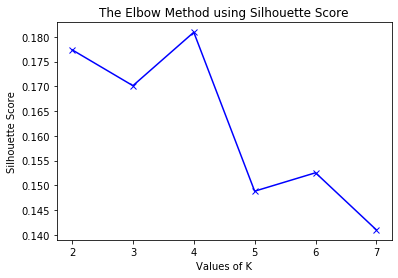

In [18]:
for key, val in mapping3.items():
    print(f'{key} : {val}')

plt.plot(K, sihouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('The Elbow Method using Silhouette Score')
plt.show()

2 : 2.307431388294636
3 : 2.1809718335338926
4 : 2.091174946399623
5 : 2.0005169395122104
6 : 1.9484277315805882
7 : 1.9021212978525541


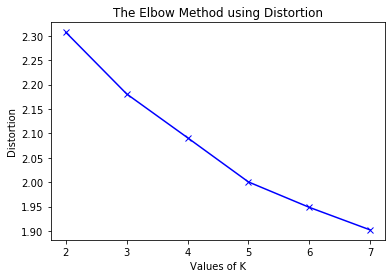

In [19]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### We see a leveling-off effect with inertia at 4 segments that confirms our earlier conclusion

2 : 53528.79168809689
3 : 48048.92413038108
4 : 42996.697121751604
5 : 39690.594259568505
6 : 37062.84792951383
7 : 35310.6437321248


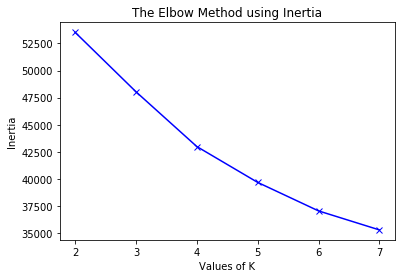

In [20]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Silhouette plots show the score on the bottom and the thickness of the graph shows the size of the cluster. There is one very small cluster in our 4-cluster model. This is something you should always explore, but it will take business domain knowledge to indicate whether this makes sense or not.

For n_clusters = 2 The average silhouette_score is : 0.17745398636589568
For n_clusters = 3 The average silhouette_score is : 0.1701316520874648
For n_clusters = 4 The average silhouette_score is : 0.1809260218536356
For n_clusters = 5 The average silhouette_score is : 0.14891890402442545
For n_clusters = 6 The average silhouette_score is : 0.1524270412721184
For n_clusters = 7 The average silhouette_score is : 0.14106776740804283
For n_clusters = 8 The average silhouette_score is : 0.1268135023005499


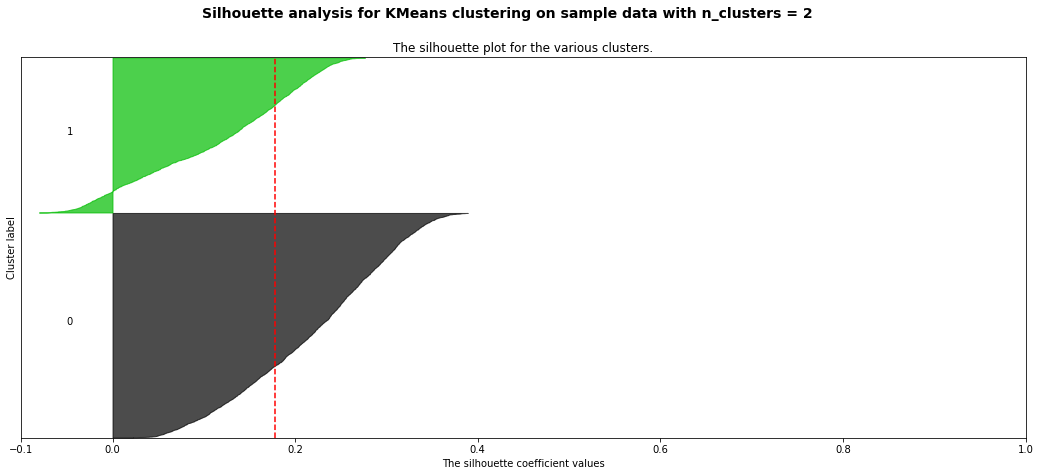

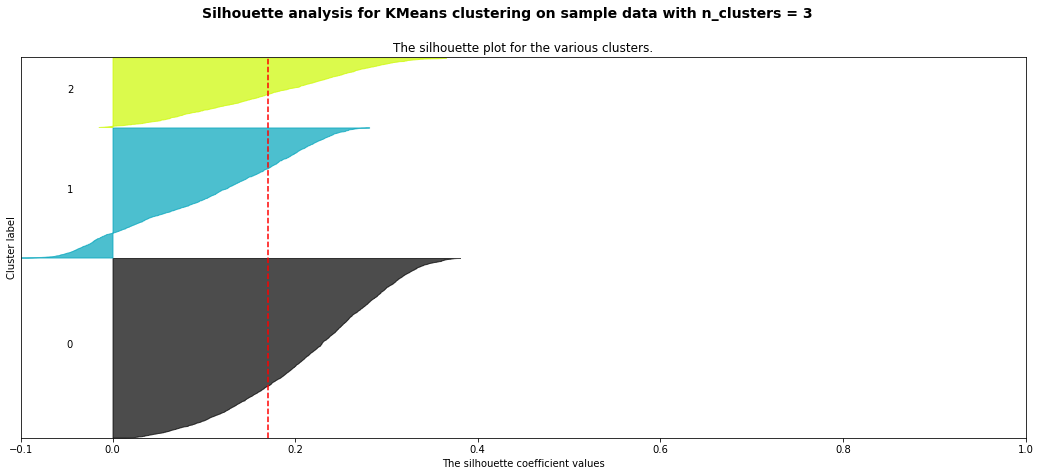

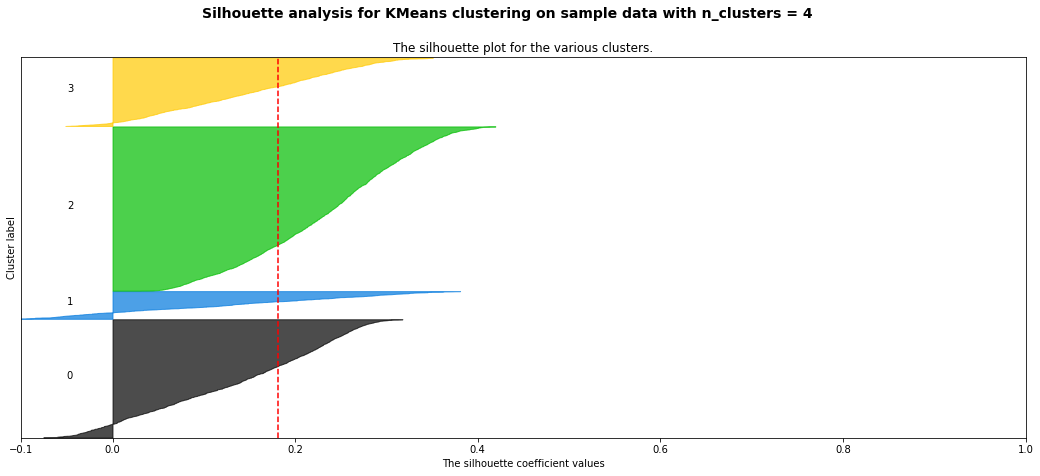

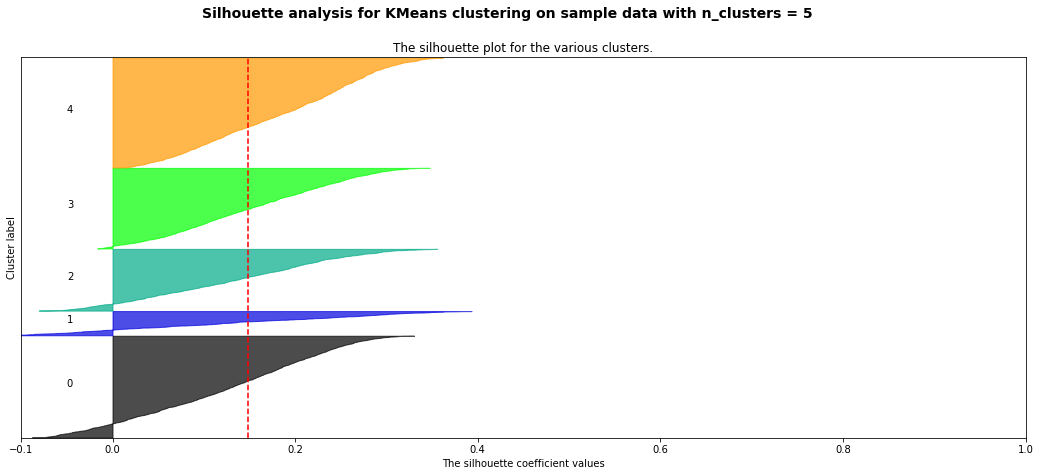

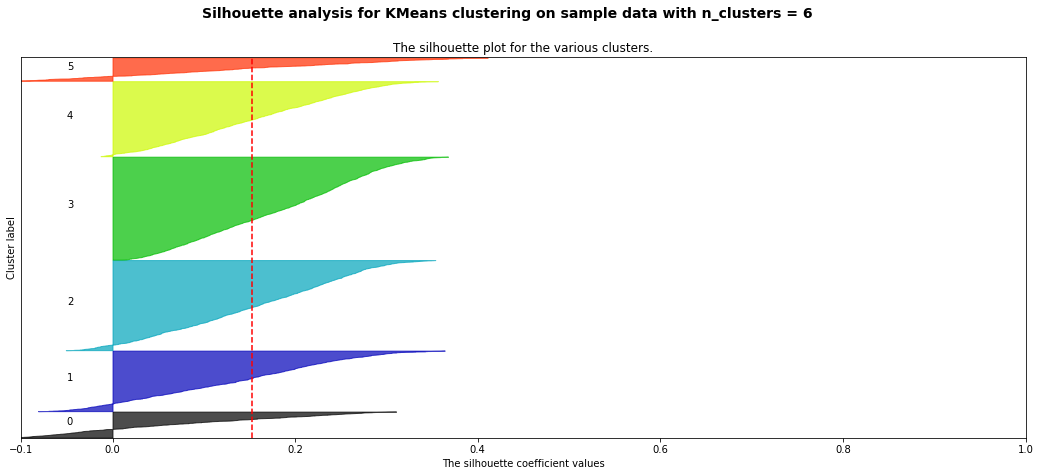

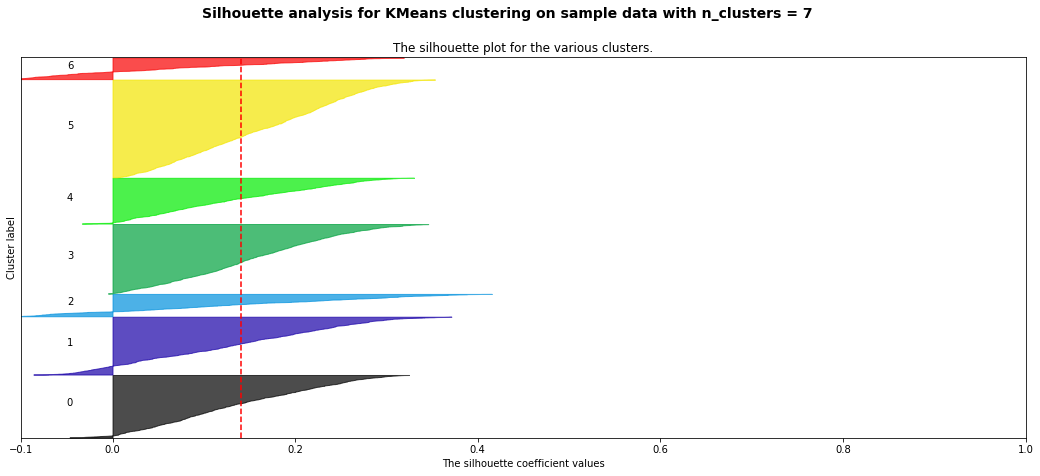

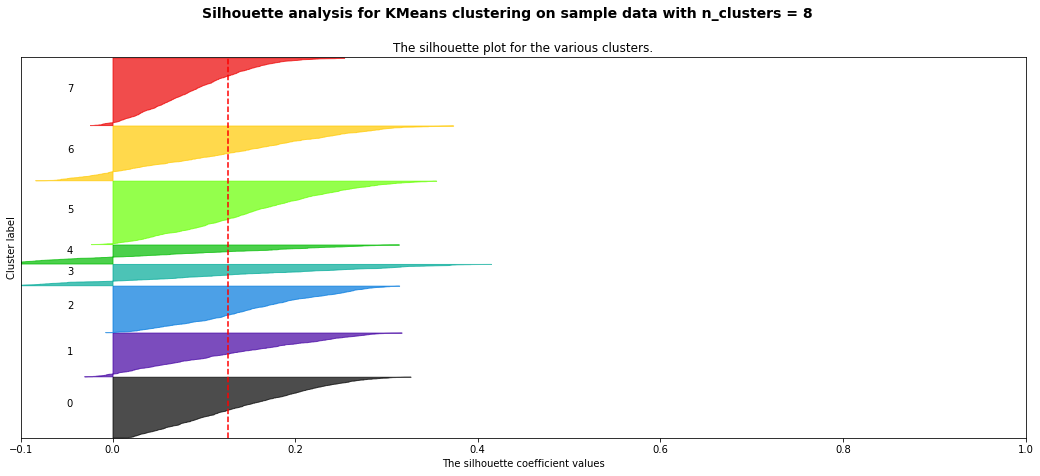

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pp_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pp_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pp_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pp_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Adding principle component analysis before the K-Means model to reduce the negative impact of highly correlated with features.

### Exploring possible numbers of components for the PCA model. Trying 8 first because we are seeing a leveling off effect after 8 components. 5 or 6 would also be options to try for this reason.

In [22]:
pca = PCA(n_components=10)
pca.fit(pp_data)
print(pca.explained_variance_ratio_)

pca.explained_variance_ratio_.sum()

[0.23579307 0.1573487  0.14326591 0.14069443 0.0863231  0.05427175
 0.04861587 0.04746114 0.02584878 0.01598884]


0.9556115849270311

In [23]:
pca = PCA(n_components=8)
pca.fit(pp_data)
print(pca.explained_variance_ratio_)

pca.explained_variance_ratio_.sum()

[0.23579307 0.1573487  0.14326591 0.14069443 0.0863231  0.05427175
 0.04861587 0.04746114]


0.913773972264149

In [24]:
pca_n_comp = 8
distortions = []
inertias = []
sihouette_scores = []
mapping1 = {}
mapping2 = {}
mapping3 = {}
K = range(2, 8)

for k in K:

    # Building and fitting the model
    pca = PCA(n_components=pca_n_comp)
    model = KMeans(n_clusters=k, random_state=10)
    
    pca_data = pca.fit_transform(pp_data)
    kmeanModel = model.fit(pca_data)
 
    distortions.append(sum(np.min(cdist(pca_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pca_data.shape[0])
    inertias.append(kmeanModel.inertia_)
    sihouette_scores.append(silhouette_score(pca_data, kmeanModel.labels_, metric='euclidean'))
 
    mapping1[k] = sum(np.min(cdist(pca_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / pca_data.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
    mapping3[k] = silhouette_score(pca_data, kmeanModel.labels_, metric='euclidean')

2 : 0.18810446471630535
3 : 0.1853956771074685
4 : 0.1976724584312799
5 : 0.16696165020874656
6 : 0.1717302796321172
7 : 0.1575187137530332


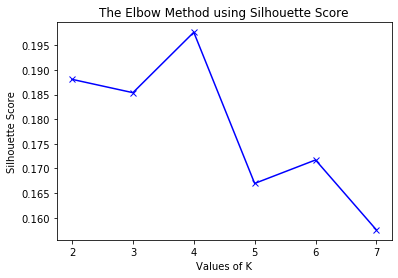

In [25]:
for key, val in mapping3.items():
    print(f'{key} : {val}')

plt.plot(K, sihouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('The Elbow Method using Silhouette Score')
plt.show()

2 : 2.171194256077534
3 : 2.0368479334641605
4 : 1.9429223406320706
5 : 1.8466514024237874
6 : 1.790832353484537
7 : 1.7398419547996455


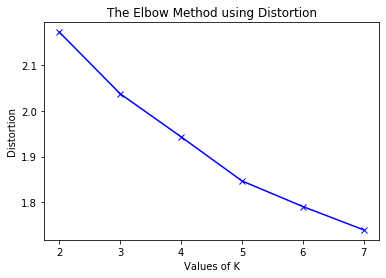

In [26]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

2 : 48052.941156601126
3 : 42555.499915437016
4 : 37520.62677216077
5 : 34226.46307184357
6 : 31596.875849359814
7 : 29851.25556778444


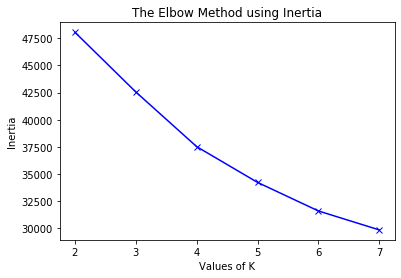

In [27]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [28]:
pca_n_comp = 6
distortions = []
inertias = []
sihouette_scores = []
mapping1 = {}
mapping2 = {}
mapping3 = {}
K = range(2, 8)

for k in K:

    # Building and fitting the model
    pca = PCA(n_components=pca_n_comp)
    model = KMeans(n_clusters=k, random_state=10)
    
    pca_data = pca.fit_transform(pp_data)
    kmeanModel = model.fit(pca_data)
 
    distortions.append(sum(np.min(cdist(pca_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pca_data.shape[0])
    inertias.append(kmeanModel.inertia_)
    sihouette_scores.append(silhouette_score(pca_data, kmeanModel.labels_, metric='euclidean'))
 
    mapping1[k] = sum(np.min(cdist(pca_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / pca_data.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
    mapping3[k] = silhouette_score(pca_data, kmeanModel.labels_, metric='euclidean')

2 : 0.213010568664397
3 : 0.21403970136971928
4 : 0.22890165454467243
5 : 0.19988544324796512
6 : 0.2062332118828631
7 : 0.1918193337014431


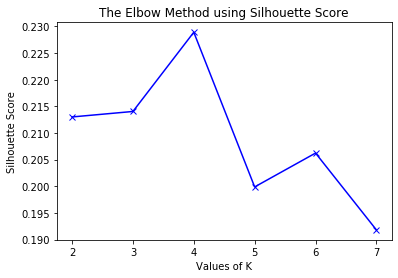

In [29]:
for key, val in mapping3.items():
    print(f'{key} : {val}')

plt.plot(K, sihouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('The Elbow Method using Silhouette Score')
plt.show()

2 : 1.9972641152593198
3 : 1.8508372780419284
4 : 1.7501295854900063
5 : 1.642646495594546
6 : 1.5819168170171403
7 : 1.5243892980618832


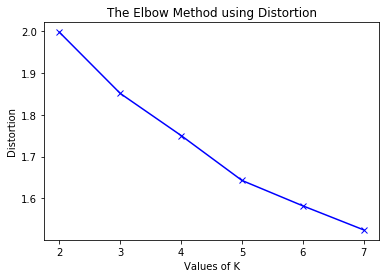

In [30]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

2 : 41876.16417733526
3 : 36380.572941642364
4 : 31347.16062809944
5 : 28056.64666424607
6 : 25425.5764060638
7 : 23680.424375419676


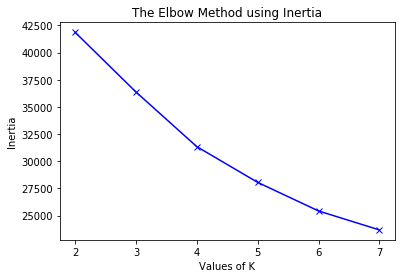

In [31]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Trying 6 principal components to see if the evaluation metrics increase. It looks like they do!

For n_clusters = 2 The average silhouette_score is : 0.2130105686643384
For n_clusters = 3 The average silhouette_score is : 0.2140397013696685
For n_clusters = 4 The average silhouette_score is : 0.2289016545442333
For n_clusters = 5 The average silhouette_score is : 0.19988544324778576
For n_clusters = 6 The average silhouette_score is : 0.20623321188304972
For n_clusters = 7 The average silhouette_score is : 0.19181933370169507
For n_clusters = 8 The average silhouette_score is : 0.19391677099608945


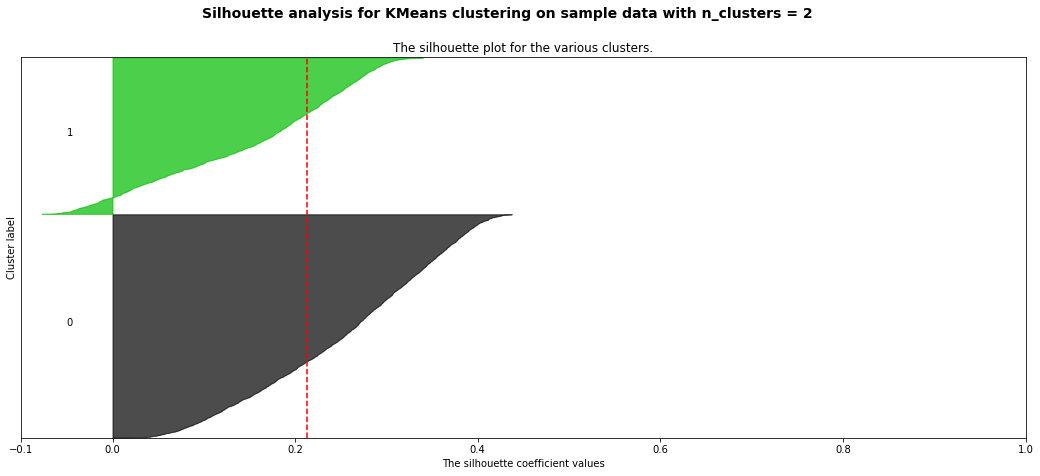

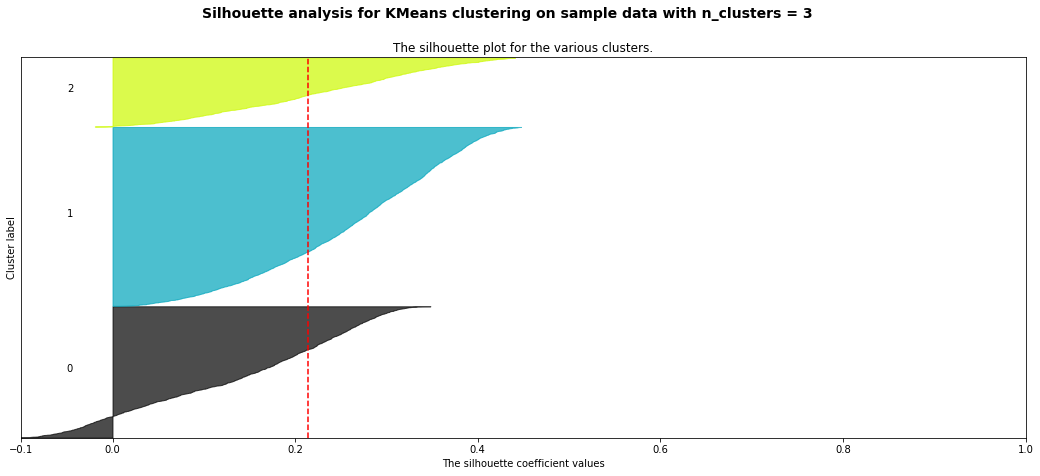

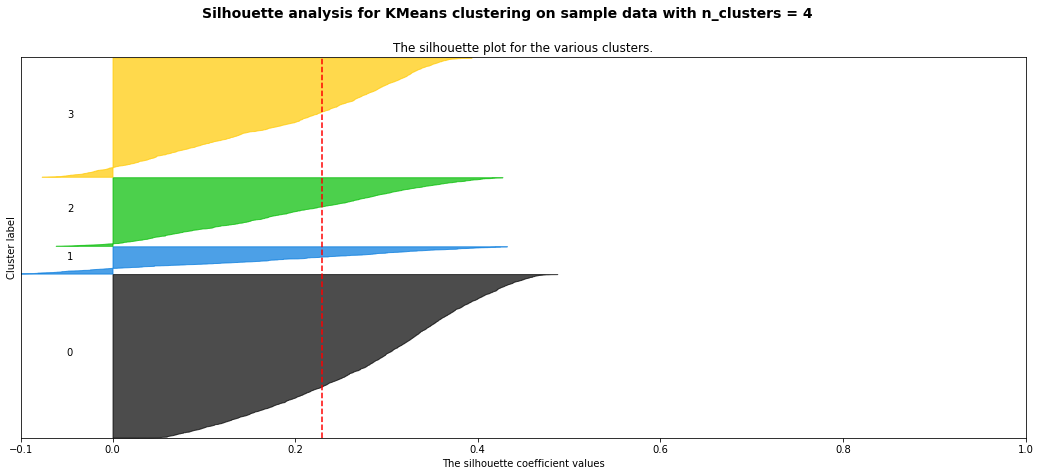

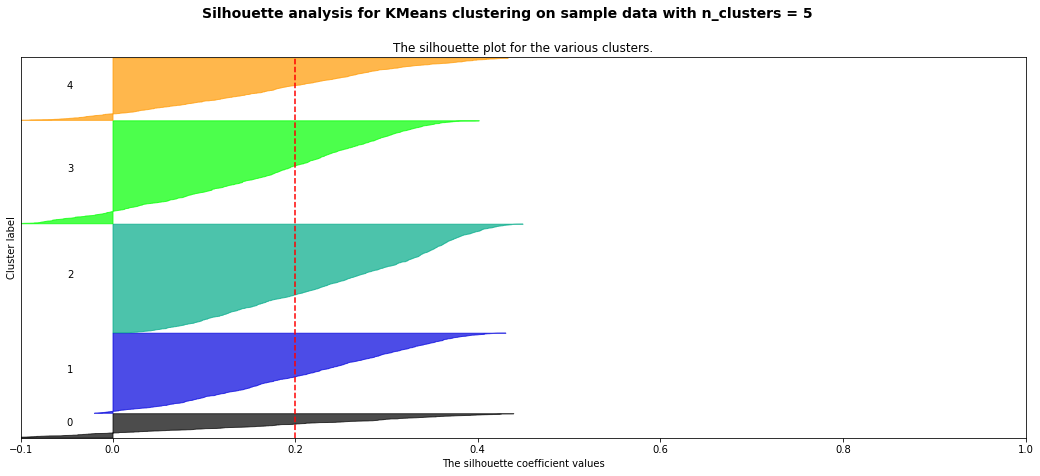

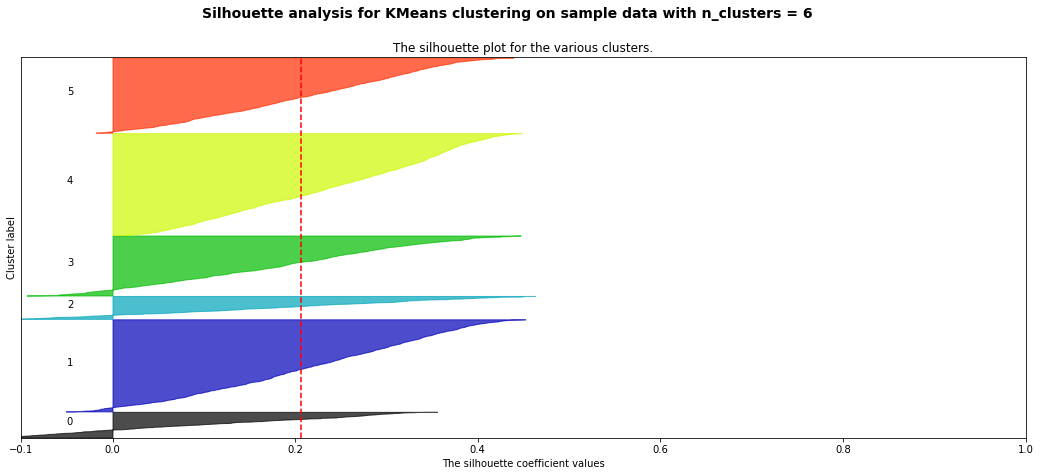

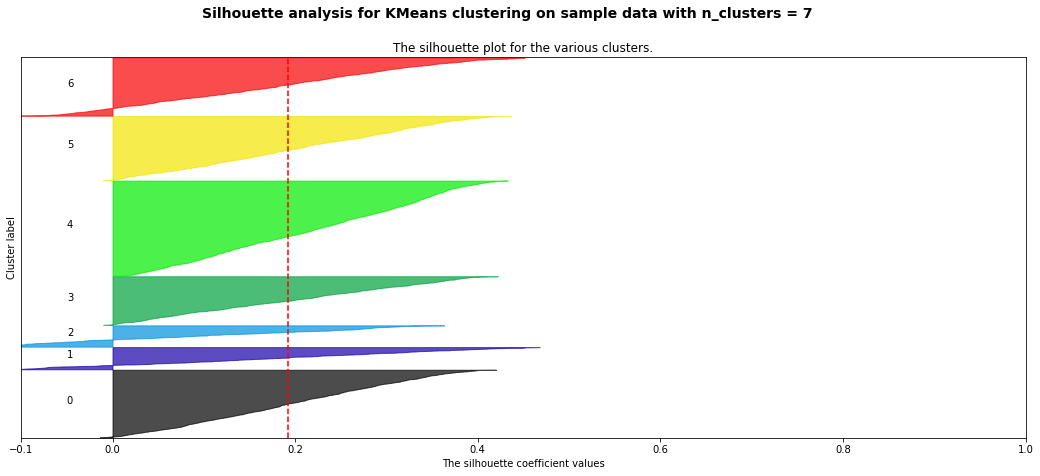

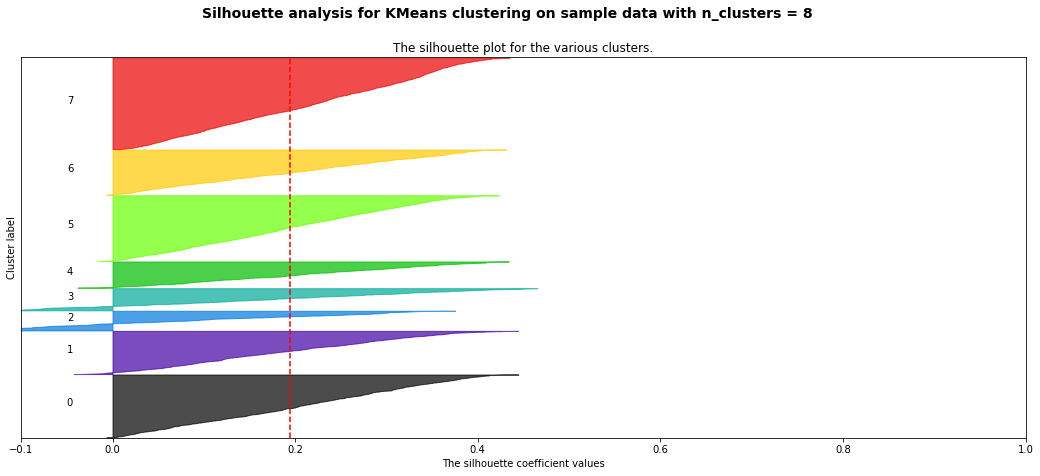

In [32]:
pca_n_comp = 6

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pp_data) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    pca = PCA(n_components=pca_n_comp)
    model = KMeans(n_clusters=n_clusters, random_state=10)

    pca_data = pca.fit_transform(pp_data)
    kmeanModel = model.fit(pca_data)
    
    clusterer = Pipeline(steps=[('pca', pca), ('model', model)])

    cluster_labels = clusterer.fit_predict(pca_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pca_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Settling on a specific model to test. Business usefulness matters a large deal in segmentation. There are many different "right" answers to choose from that have good metrics. Always run them by your business stakeholders early!

In [33]:
pca_n_comp = 6

pca = PCA(n_components=pca_n_comp)
model = KMeans(n_clusters=4)

pca_data = pca.fit_transform(pp_data)
model.fit(pca_data)
#model_results = model.transform(pca_data)

data_wresults = pd.concat([customers, pd.DataFrame(model.labels_)],axis=1)
data_wresults.rename(columns={0:'cluster'},inplace=True)

print('silhouette score is: ' + str(metrics.silhouette_score(pca_data, model.labels_, metric='euclidean')))
print('model inertia is: ' + str(model.inertia_))
print('model distortion is: ' + str(sum(np.min(cdist(pca_data, model.cluster_centers_, 'euclidean'), axis=1)) / pca_data.shape[0]))

silhouette score is: 0.22888700557827135
model inertia is: 31347.13810445404
model distortion is: 1.7501205711454897


#### Seeing a large income and CLV effect in this model, which is promising. We are seeing no recency effect which is unusual for this type of data. We are also seeing monthly premiums and total claim amounts differ across segment.

In [34]:
continuous_columns = ['Income','CLV','MonthlyPremiumAuto','MonthsSinceLastClaim','NumberOfOpenComplaints',
                      'NumberOfPolicies','TotalClaimAmount','MonthsSincePolicyInception']

data_wresults.groupby('cluster')[continuous_columns].mean()

,Income,CLV,MonthlyPremiumAuto,MonthsSinceLastClaim,NumberOfOpenComplaints,NumberOfPolicies,TotalClaimAmount,MonthsSincePolicyInception
cluster,,,,,,,,
0,40741.419686,6954.731364,89.956522,15.308575,0.403986,7.310386,389.724933,46.978865
1,7701.464186,6606.584071,97.760431,15.308067,0.391864,2.167594,604.076616,48.000695
2,57938.544394,6235.494128,87.121005,14.740994,0.383815,1.862506,308.492386,48.407661
3,39320.553030,27301.875029,118.040909,15.772727,0.306061,2.137879,554.820037,49.018182


#### Notice that our segment that is most different above is much smaller than the others

In [35]:
segment_counts = pd.DataFrame(data_wresults.groupby('cluster')['Customer'].count()).reset_index()
segment_counts

,cluster,Customer
0,0,1656
1,1,2876
2,2,3942
3,3,660


In [36]:
educ_counts = pd.DataFrame(data_wresults.groupby(['cluster','Education'])['Customer'].count()).reset_index()
educ_counts.rename(columns={'Customer':'count'},inplace=True)
educ_pcts = pd.merge(educ_counts,segment_counts)
educ_pcts['educ_pct'] = educ_pcts['count']/educ_pcts['Customer']
educ_pcts = educ_pcts.drop(columns=['count','Customer'])

educ_pcts.sort_values(['Education','cluster'])

,cluster,Education,educ_pct
0,0,Bachelor,0.303744
5,1,Bachelor,0.317107
10,2,Bachelor,0.289447
15,3,Bachelor,0.290909
1,0,College,0.279589
6,1,College,0.295549
11,2,College,0.302638
16,3,College,0.265152
2,0,Doctor,0.044082
7,1,Doctor,0.022253


#### As we would expect the highest value segment has the highest percentage of people in the Extended and Premium plans

In [37]:
coverage_type_counts = pd.DataFrame(data_wresults.groupby(['cluster','Coverage'])['Customer'].count()).reset_index()
coverage_type_counts.rename(columns={'Customer':'count'},inplace=True)
coverage_type_pcts = pd.merge(coverage_type_counts,segment_counts)
coverage_type_pcts['coverage_type_pct'] = coverage_type_pcts['count']/coverage_type_pcts['Customer']
coverage_type_pcts = coverage_type_pcts.drop(columns=['count','Customer'])

coverage_type_pcts.sort_values(['Coverage','cluster'])

,cluster,Coverage,coverage_type_pct
0,0,Basic,0.620169
3,1,Basic,0.583102
6,2,Basic,0.640538
9,3,Basic,0.513636
1,0,Extended,0.301329
4,1,Extended,0.310848
7,2,Extended,0.282090
10,3,Extended,0.359091
2,0,Premium,0.078502
5,1,Premium,0.106050


#### We are seeing very little difference between sales channel by segment. If this was a marketing segmentation, this may make this segmentation less useful.

In [38]:
channel_counts = pd.DataFrame(data_wresults.groupby(['cluster','SalesChannel'])['Customer'].count()).reset_index()
channel_counts.rename(columns={'Customer':'count'},inplace=True)
channel_pcts = pd.merge(channel_counts,segment_counts)
channel_pcts['channel_pct'] = channel_pcts['count']/channel_pcts['Customer']
channel_pcts = channel_pcts.drop(columns=['count','Customer'])

channel_pcts.sort_values(['SalesChannel','cluster'])

,cluster,SalesChannel,channel_pct
0,0,Agent,0.373792
4,1,Agent,0.394645
8,2,Agent,0.377727
12,3,Agent,0.354545
1,0,Branch,0.276570
5,1,Branch,0.267038
9,2,Branch,0.286403
13,3,Branch,0.321212
2,0,Call Center,0.198671
6,1,Call Center,0.191933


## Segmentation Example 3

In [39]:
cat_vars = ['Education','PolicyType','CoverageOrdered','MaritalStatus']
cont_vars = ['CLV','Income','NumberOfPolicies','MonthlyPremiumAuto',
             'NumberOfOpenComplaints']

In [40]:
ohe = OneHotEncoder()
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_vars),
        ('cont', scaler, cont_vars)])

pp_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

pp_data = pp_pipe.fit_transform(customer_modeling)

In [41]:
pca_n_comp = 6
distortions = []
inertias = []
sihouette_scores = []
mapping1 = {}
mapping2 = {}
mapping3 = {}
K = range(2, 8)

for k in K:

    # Building and fitting the model
    pca = PCA(n_components=pca_n_comp)
    model = KMeans(n_clusters=k, random_state=10)
    
    pca_data = pca.fit_transform(pp_data)
    kmeanModel = model.fit(pca_data)
 
    distortions.append(sum(np.min(cdist(pca_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pca_data.shape[0])
    inertias.append(kmeanModel.inertia_)
    sihouette_scores.append(silhouette_score(pca_data, kmeanModel.labels_, metric='euclidean'))
 
    mapping1[k] = sum(np.min(cdist(pca_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / pca_data.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
    mapping3[k] = silhouette_score(pca_data, kmeanModel.labels_, metric='euclidean')

#### Our new features look like they are leading the segments to differentiate more! Let's see if the summary statistics confirm this

2 : 0.27316475926598033
3 : 0.24027036359377957
4 : 0.26526803662503096
5 : 0.23476942038679297
6 : 0.24985733490984172
7 : 0.2219171234349359


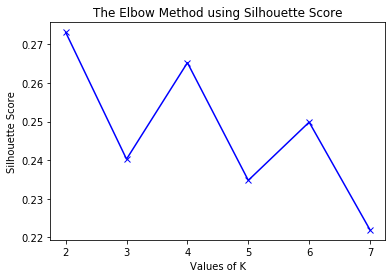

In [42]:
for key, val in mapping3.items():
    print(f'{key} : {val}')

plt.plot(K, sihouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('The Elbow Method using Silhouette Score')
plt.show()

2 : 1.993895135500544
3 : 1.8021103096268078
4 : 1.6698553091434156
5 : 1.5209744549734077
6 : 1.4532641017550885
7 : 1.3885959088598627


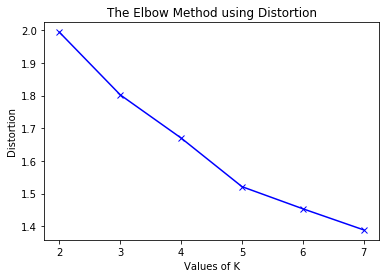

In [43]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

2 : 42084.27669291545
3 : 35218.890506094336
4 : 29105.769508870108
5 : 24667.95174941007
6 : 22006.983416611067
7 : 20417.50898338044


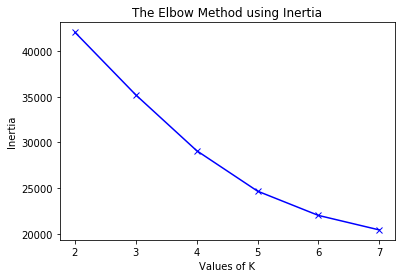

In [44]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [45]:
pca_n_comp = 6

pca = PCA(n_components=pca_n_comp)
model = KMeans(n_clusters=4)

pca_data = pca.fit_transform(pp_data)
model.fit(pca_data)
#model_results = model.transform(pca_data)

data_wresults = pd.concat([customers, pd.DataFrame(model.labels_)],axis=1)
data_wresults.rename(columns={0:'cluster'},inplace=True)

print('silhouette score is: ' + str(metrics.silhouette_score(pca_data, model.labels_, metric='euclidean')))
print('model inertia is: ' + str(model.inertia_))
print('model distortion is: ' + str(sum(np.min(cdist(pca_data, model.cluster_centers_, 'euclidean'), axis=1)) / pca_data.shape[0]))

silhouette score is: 0.26545946909537693
model inertia is: 29105.39782715203
model distortion is: 1.6703851214477436


#### There is much less of an income effect in these segments. We see very large differences in CLV, monthly premium, number of complaints, total claim amount, and number of policies. It looks like this does a better job differentiating on the business metrics that will matter to an insurance agency!

In [46]:
continuous_columns = ['Income','CLV','MonthlyPremiumAuto','MonthsSinceLastClaim','NumberOfOpenComplaints',
                      'NumberOfPolicies','TotalClaimAmount','MonthsSincePolicyInception']

data_wresults.groupby('cluster')[continuous_columns].mean()

,Income,CLV,MonthlyPremiumAuto,MonthsSinceLastClaim,NumberOfOpenComplaints,NumberOfPolicies,TotalClaimAmount,MonthsSincePolicyInception
cluster,,,,,,,,
0,36526.097697,19541.280915,145.430500,15.273233,0.208102,2.447180,706.243441,48.275616
1,37477.229131,6593.242139,85.920553,15.018423,0.169833,7.083477,398.950716,47.006908
2,38166.551499,6359.213360,87.611473,15.357236,2.973924,2.731421,401.973434,48.638853
3,37908.110222,5992.305974,84.141873,15.043940,0.125303,1.789797,386.243816,48.275182


#### The bulk of the dataset is sitting in the worst segment. This is extremely common. Usually in a lot of circumstances there are a small number of "super users" and the bulk of the audience is unengaged.

In [47]:
segment_counts = pd.DataFrame(data_wresults.groupby('cluster')['Customer'].count()).reset_index()
segment_counts

,cluster,Customer
0,0,1259
1,1,1737
2,2,767
3,3,5371


In [48]:
educ_counts = pd.DataFrame(data_wresults.groupby(['cluster','Education'])['Customer'].count()).reset_index()
educ_counts.rename(columns={'Customer':'count'},inplace=True)
educ_pcts = pd.merge(educ_counts,segment_counts)
educ_pcts['educ_pct'] = educ_pcts['count']/educ_pcts['Customer']
educ_pcts = educ_pcts.drop(columns=['count','Customer'])

educ_pcts.sort_values(['Education','cluster'])

,cluster,Education,educ_pct
0,0,Bachelor,0.298650
5,1,Bachelor,0.303397
10,2,Bachelor,0.322034
15,3,Bachelor,0.297524
1,0,College,0.263701
6,1,College,0.285550
11,2,College,0.323338
16,3,College,0.298827
2,0,Doctor,0.034948
7,1,Doctor,0.037421


#### Segment 2 is by far the most likely to have a higher-value plan. Based on the other metrics this seems like the "super-user" group

In [49]:
coverage_type_counts = pd.DataFrame(data_wresults.groupby(['cluster','Coverage'])['Customer'].count()).reset_index()
coverage_type_counts.rename(columns={'Customer':'count'},inplace=True)
coverage_type_pcts = pd.merge(coverage_type_counts,segment_counts)
coverage_type_pcts['coverage_type_pct'] = coverage_type_pcts['count']/coverage_type_pcts['Customer']
coverage_type_pcts = coverage_type_pcts.drop(columns=['count','Customer'])

coverage_type_pcts.sort_values(['Coverage','cluster'])

,cluster,Coverage,coverage_type_pct
0,0,Basic,0.353455
3,1,Basic,0.636154
6,2,Basic,0.621904
9,3,Basic,0.659281
1,0,Extended,0.399523
4,1,Extended,0.294185
7,2,Extended,0.308996
10,3,Extended,0.277602
2,0,Premium,0.247021
5,1,Premium,0.069660


In [50]:
channel_counts = pd.DataFrame(data_wresults.groupby(['cluster','SalesChannel'])['Customer'].count()).reset_index()
channel_counts.rename(columns={'Customer':'count'},inplace=True)
channel_pcts = pd.merge(channel_counts,segment_counts)
channel_pcts['channel_pct'] = channel_pcts['count']/channel_pcts['Customer']
channel_pcts = channel_pcts.drop(columns=['count','Customer'])

channel_pcts.sort_values(['SalesChannel','cluster'])

,cluster,SalesChannel,channel_pct
0,0,Agent,0.373312
4,1,Agent,0.370178
8,2,Agent,0.402868
12,3,Agent,0.382610
1,0,Branch,0.292295
5,1,Branch,0.274036
9,2,Branch,0.258149
13,3,Branch,0.283932
2,0,Call Center,0.190627
6,1,Call Center,0.211860


#### We are seeing very little difference between corporate, personal, and special, which is surprising since segment 3 has an average of over 7 policies.

In [51]:
policy_type_counts = pd.DataFrame(data_wresults.groupby(['cluster','PolicyType'])['Customer'].count()).reset_index()
policy_type_counts.rename(columns={'Customer':'count'},inplace=True)
policy_type_pcts = pd.merge(policy_type_counts,segment_counts)
policy_type_pcts['channel_pct'] = policy_type_pcts['count']/policy_type_pcts['Customer']
policy_type_pcts = policy_type_pcts.drop(columns=['count','Customer'])

policy_type_pcts.sort_values(['PolicyType','cluster'])

,cluster,PolicyType,channel_pct
0,0,Corporate Auto,0.213662
3,1,Corporate Auto,0.221647
6,2,Corporate Auto,0.195567
9,3,Corporate Auto,0.216719
1,0,Personal Auto,0.741859
4,1,Personal Auto,0.736327
7,2,Personal Auto,0.758801
10,3,Personal Auto,0.743437
2,0,Special Auto,0.044480
5,1,Special Auto,0.042026


## Segmentation Example 4

In [52]:
cat_vars = ['PolicyType','CoverageOrdered']
cont_vars = ['CLV','Income','MonthsSinceLastClaim','NumberOfPolicies','MonthlyPremiumAuto',
             'NumberOfOpenComplaints']

In [53]:
ohe = OneHotEncoder()
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_vars),
        ('cont', scaler, cont_vars)])

pp_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

pp_data = pp_pipe.fit_transform(customer_modeling)

In [54]:
pca_n_comp = 6
distortions = []
inertias = []
sihouette_scores = []
mapping1 = {}
mapping2 = {}
mapping3 = {}
K = range(2, 8)

for k in K:

    # Building and fitting the model
    pca = PCA(n_components=pca_n_comp)
    model = KMeans(n_clusters=k, random_state=10)
    
    pca_data = pca.fit_transform(pp_data)
    kmeanModel = model.fit(pca_data)
 
    distortions.append(sum(np.min(cdist(pca_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / pca_data.shape[0])
    inertias.append(kmeanModel.inertia_)
    sihouette_scores.append(silhouette_score(pca_data, kmeanModel.labels_, metric='euclidean'))
 
    mapping1[k] = sum(np.min(cdist(pca_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / pca_data.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
    mapping3[k] = silhouette_score(pca_data, kmeanModel.labels_, metric='euclidean')

#### This segmentation has lower silhouette scores

2 : 0.25447679585313826
3 : 0.2133674486612753
4 : 0.23439157575946123
5 : 0.2027631964627707
6 : 0.19720475928394388
7 : 0.20958063357502263


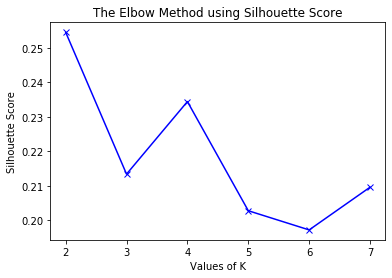

In [55]:
for key, val in mapping3.items():
    print(f'{key} : {val}')

plt.plot(K, sihouette_scores, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('The Elbow Method using Silhouette Score')
plt.show()

2 : 2.1440870226824686
3 : 1.964296016909708
4 : 1.8392518009311543
5 : 1.705370461170496
6 : 1.6043662041295443
7 : 1.5428955978914654


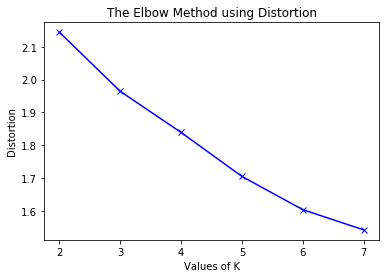

In [56]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

2 : 47610.38035430992
3 : 40748.97037973722
4 : 34641.70397226308
5 : 30298.210625592037
6 : 27284.35017972769
7 : 24774.26367923559


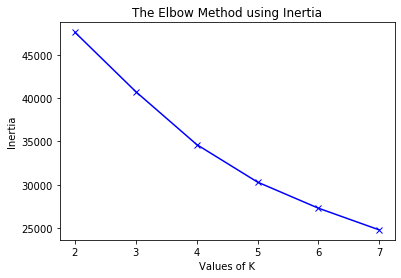

In [57]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [58]:
pca_n_comp = 6

pca = PCA(n_components=pca_n_comp)
model = KMeans(n_clusters=4)

pca_data = pca.fit_transform(pp_data)
model.fit(pca_data)
#model_results = model.transform(pca_data)

data_wresults = pd.concat([customers, pd.DataFrame(model.labels_)],axis=1)
data_wresults.rename(columns={0:'cluster'},inplace=True)

print('silhouette score is: ' + str(metrics.silhouette_score(pca_data, model.labels_, metric='euclidean')))
print('model inertia is: ' + str(model.inertia_))
print('model distortion is: ' + str(sum(np.min(cdist(pca_data, model.cluster_centers_, 'euclidean'), axis=1)) / pca_data.shape[0]))

silhouette score is: 0.23439157575937353
model inertia is: 34641.70397226308
model distortion is: 1.839251800931154


#### Segments are less differentiated on important business metrics. The "less valuable" segments look very similar to one another.

In [59]:
continuous_columns = ['Income','CLV','MonthlyPremiumAuto','MonthsSinceLastClaim','NumberOfOpenComplaints',
                      'NumberOfPolicies','TotalClaimAmount','MonthsSincePolicyInception']

data_wresults.groupby('cluster')[continuous_columns].mean()

,Income,CLV,MonthlyPremiumAuto,MonthsSinceLastClaim,NumberOfOpenComplaints,NumberOfPolicies,TotalClaimAmount,MonthsSincePolicyInception
cluster,,,,,,,,
0,37484.576037,6591.109522,85.895737,15.015553,0.169931,7.084677,398.823845,47.033986
1,37855.426454,5916.683345,84.052908,15.006567,0.124578,1.787054,386.321960,48.256660
2,36737.520338,19413.124500,143.808903,15.432080,0.211051,2.438987,695.846835,48.309286
3,38236.435294,6331.681980,87.535948,15.341176,2.976471,2.733333,401.077619,48.648366


In [60]:
segment_counts = pd.DataFrame(data_wresults.groupby('cluster')['Customer'].count()).reset_index()
segment_counts

,cluster,Customer
0,0,1736
1,1,5330
2,2,1303
3,3,765


In [61]:
educ_counts = pd.DataFrame(data_wresults.groupby(['cluster','Education'])['Customer'].count()).reset_index()
educ_counts.rename(columns={'Customer':'count'},inplace=True)
educ_pcts = pd.merge(educ_counts,segment_counts)
educ_pcts['educ_pct'] = educ_pcts['count']/educ_pcts['Customer']
educ_pcts = educ_pcts.drop(columns=['count','Customer'])

educ_pcts.sort_values(['Education','cluster'])

,cluster,Education,educ_pct
0,0,Bachelor,0.303571
5,1,Bachelor,0.296811
10,2,Bachelor,0.300844
15,3,Bachelor,0.322876
1,0,College,0.285138
6,1,College,0.299250
11,2,College,0.264774
16,3,College,0.321569
2,0,Doctor,0.037442
7,1,Doctor,0.037899


#### This confirms what I stated above. Only the "best" segment is differentiating on coverage type

In [62]:
coverage_type_counts = pd.DataFrame(data_wresults.groupby(['cluster','Coverage'])['Customer'].count()).reset_index()
coverage_type_counts.rename(columns={'Customer':'count'},inplace=True)
coverage_type_pcts = pd.merge(coverage_type_counts,segment_counts)
coverage_type_pcts['coverage_type_pct'] = coverage_type_pcts['count']/coverage_type_pcts['Customer']
coverage_type_pcts = coverage_type_pcts.drop(columns=['count','Customer'])

coverage_type_pcts.sort_values(['Coverage','cluster'])

,cluster,Coverage,coverage_type_pct
0,0,Basic,0.636521
3,1,Basic,0.660976
6,2,Basic,0.355334
9,3,Basic,0.623529
1,0,Extended,0.293779
4,1,Extended,0.276548
7,2,Extended,0.400614
10,3,Extended,0.308497
2,0,Premium,0.069700
5,1,Premium,0.062477


In [63]:
channel_counts = pd.DataFrame(data_wresults.groupby(['cluster','SalesChannel'])['Customer'].count()).reset_index()
channel_counts.rename(columns={'Customer':'count'},inplace=True)
channel_pcts = pd.merge(channel_counts,segment_counts)
channel_pcts['channel_pct'] = channel_pcts['count']/channel_pcts['Customer']
channel_pcts = channel_pcts.drop(columns=['count','Customer'])

channel_pcts.sort_values(['SalesChannel','cluster'])

,cluster,SalesChannel,channel_pct
0,0,Agent,0.370392
4,1,Agent,0.381989
8,2,Agent,0.375288
12,3,Agent,0.403922
1,0,Branch,0.273618
5,1,Branch,0.284053
9,2,Branch,0.292402
13,3,Branch,0.257516
2,0,Call Center,0.211982
6,1,Call Center,0.188180


In [64]:
policy_type_counts = pd.DataFrame(data_wresults.groupby(['cluster','PolicyType'])['Customer'].count()).reset_index()
policy_type_counts.rename(columns={'Customer':'count'},inplace=True)
policy_type_pcts = pd.merge(policy_type_counts,segment_counts)
policy_type_pcts['channel_pct'] = policy_type_pcts['count']/policy_type_pcts['Customer']
policy_type_pcts = policy_type_pcts.drop(columns=['count','Customer'])

policy_type_pcts.sort_values(['PolicyType','cluster'])

,cluster,PolicyType,channel_pct
0,0,Corporate Auto,0.221198
3,1,Corporate Auto,0.217073
6,2,Corporate Auto,0.212586
9,3,Corporate Auto,0.196078
1,0,Personal Auto,0.736751
4,1,Personal Auto,0.743340
7,2,Personal Auto,0.742134
10,3,Personal Auto,0.758170
2,0,Special Auto,0.042051
5,1,Special Auto,0.039587


## Our second segmentation looks to be the best! We would definitely do more tuning in a real-life scenario, but this should be a good example of the process.